# TP3 Son


Victoria NGUYEN 28604687


# __Factorisation en matrices non-négatives__


In [21]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

On charge le son .wav

In [22]:
sample_rate = 5000
filename = "piano_mix.wav"
y, sr = librosa.load(filename, sr=sample_rate)



### 1) Tracer la forme d’onde et le spectrogramme en fonction des fréquences (en Hz.) et du temps (en s.). Pour calculer le spectrogramme, on veillera à décomposer la transformée de Fourier à court-terme en module et phase.


__Forme d'onde__



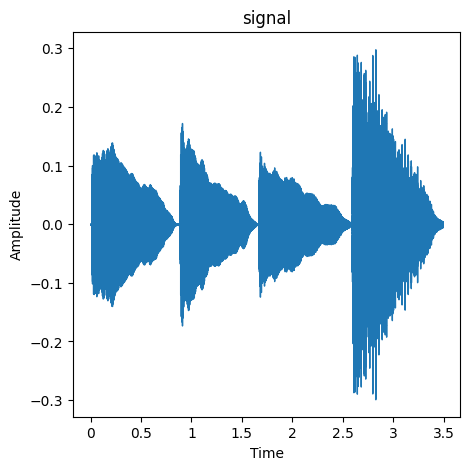

In [23]:
plt.figure(figsize=(5, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

 __Tracé des spectogrammes__

 Le spectogramme nous indique les fréquences du signal au cours du temps, via une transformation de Fourier à court terme. 

/tmp/ipykernel_17379/4239132378.py:15: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(phase, y_axis='linear')


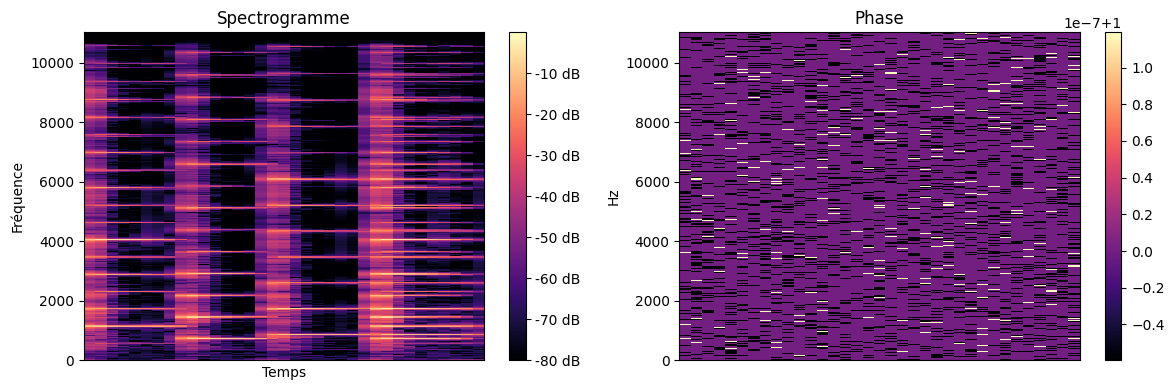

In [24]:
#Transformée de Fourier a court terme : module et phase
S_full, phase = librosa.magphase(librosa.stft(y))


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogramme')
plt.xlabel('Temps')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
librosa.display.specshow(phase, y_axis='linear')
plt.colorbar()
plt.title('Phase')
plt.tight_layout()

### 2) Implémenter l’algorithme NMF avec une fonction de coût pour la β-divergence, en utilisant les formules de mise à jour multiplicatives données dans le cours. On choisira une initialisation aléatoire pour les matrices W et H et on choisira β=2.


Si l'on prend la formule de la beta-divergence avec $\beta$ = 2, alors cela revient a choisir la fonction norme L2.


### Tracer l’évolution des matrices W, H

In [25]:
 
import matplotlib.cm as cm
import matplotlib

#l'algorithme NMF
def NMF_V1(V, S, threshold ): 
    cout = []
    beta_divergence = 1
    
    K, N = np.shape(V)
    
    W = np.abs(np.random.randn(K, S))
    H = np.abs(np.random.randn(S, N))
    
    max = 0

    while beta_divergence >= threshold and max < 100:
        
        W = W*np.dot(V, H.transpose()) / np.dot(W, np.dot(H, H.transpose()))
        H = H*np.dot(W.transpose(), V) / np.dot(np.dot(W.transpose(), W), H)

        beta_divergence =  (1/2)*np.linalg.norm(V-np.dot(W,H))**2
        cout.append( beta_divergence )

        

        #on en plot 4 en tout, donc tous les 100/4 = 25
        if max ==0 or max == 5 or max==10 or max==20 or max == 50:
            
    
            plt.figure(figsize=(3, 3))
            V_plot = plt.axes([0.35, 0.1, 1, 0.6])
            H_plot = plt.axes([0.35, 0.75, 1, 0.15])
            W_plot = plt.axes([0.1, 0.1, 0.2, 0.6])

            
            librosa.display.specshow(W,y_axis = 'hz', sr=sr, hop_length=512,x_axis ='time',cmap= matplotlib.cm.jet, ax=W_plot)
            librosa.display.specshow(H,y_axis = 'hz', sr=sr, hop_length=512,x_axis ='time',cmap= matplotlib.cm.jet, ax=H_plot)
            librosa.display.specshow(W@H,y_axis = 'hz', sr=sr, hop_length=512,x_axis ='time',cmap= matplotlib.cm.jet, ax=V_plot)
            V_plot.set_title('V')
            H_plot.set_title('H')
            W_plot.set_title('W')

            #axes
            V_plot.set_xlabel('Temps')
            V_plot.set_ylabel('Fréquence')
            H_plot.set_xlabel('Temps')
            H_plot.set_ylabel('Fréquence')
            W_plot.set_xlabel('Temps')
            W_plot.set_ylabel('Fréquence')
            
            plt.show()
        max += 1        
    return W,H, cout 
    

__Commentaires__ : 

On obtient les courbes ci-dessous. Vu que l'on a une convergence assez rapide, je choisis d'afficher les résultats vers les premières itérations afin de voir l'évolution des matrices W et H. On remarque que les matrices W et H convergent vers des valeurs constantes. Cela est attendu car on a une convergence vers un minimum local. Concernant les plots, on voit qu'au fur et a mesure, on voit bien 3 sources/activations qui se dinstinguent : cela correspond bien a ce que l'on attend .

On retrouve les 3 sources jouées en même temps dans le dernier temps (activation de grade intensité).

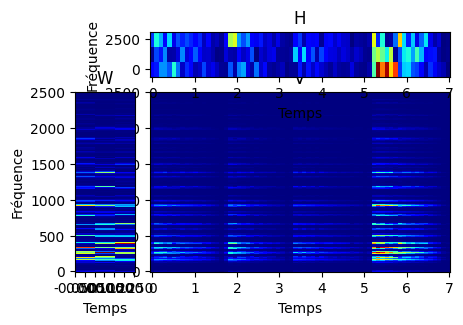

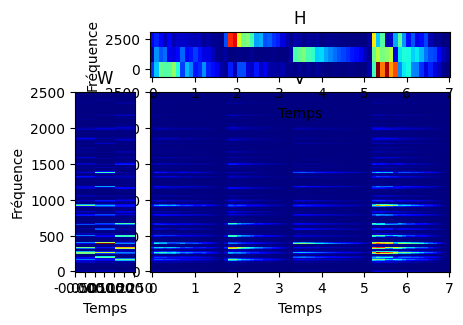

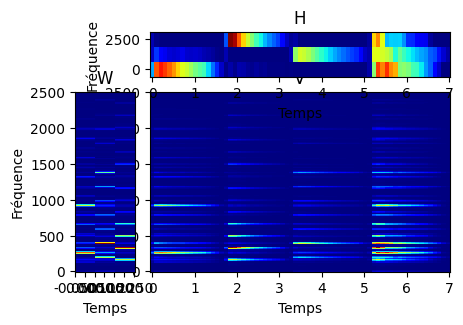

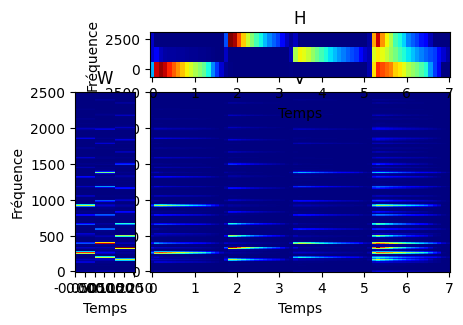

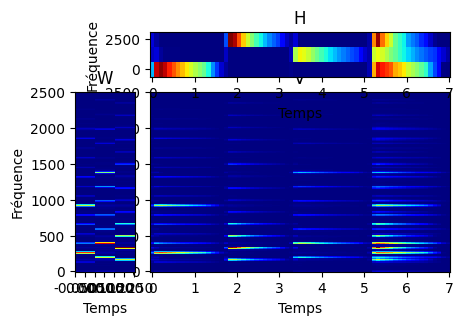

In [26]:

y_tfct = librosa.stft(y, n_fft=512,hop_length=256)
V = np.abs(y_tfct)
K, N = np.shape(V)
S = 3 #3 soua a localiser
W, H, cost_function = NMF_V1(V,S,0.05)   

__Calculer la fonction de coût pour chaque itération. Tracer l’évolution de la fonction de
coût en fonction des itérations. Qu’observe-t-on ? Est-ce attendu ?__


Le cout diminue, et atteind un plateau vers la 20eme itération. C'est attendu car on minimise la fonction de cout.

Text(0, 0.5, 'cout')

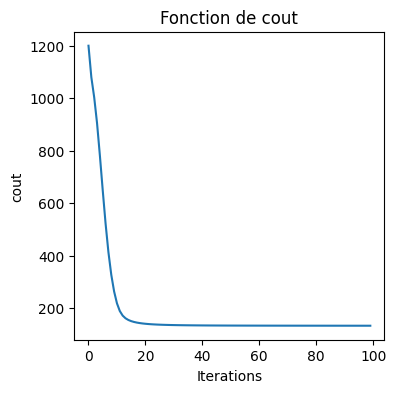

In [27]:
plt.figure(figsize=(4, 4))
plt.plot(cost_function)
plt.title('Fonction de cout')
plt.xlabel('Iterations')
plt.ylabel('cout')

### 4) A partir des matrices W, H, implémenter le filtrage de Wiener permettant de calculer le spectrogramme des sources sonores séparément.


On va essayer de séparer les 3 sources. Pour cela, on se sert de la matrice V sous forme factorisée. Le but est de reconstruire les 3 sources a partir de la matrice V.

filtered source (3, 257, 69)


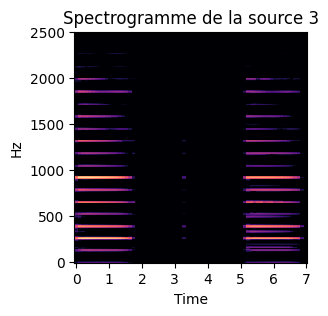

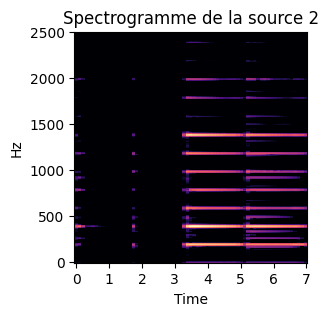

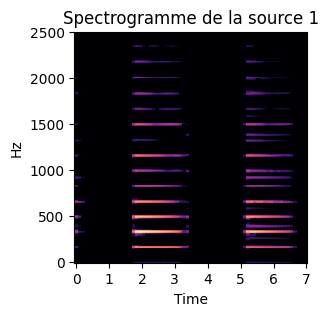

In [29]:

filtered_source = []

for i in range(0,S):
    wi_Hi =  np.dot(W[:,i].reshape(K,1), H[i,:].reshape(1,N))
    source = wi_Hi / np.sum(W@H, axis=0)*V
    filtered_source.append(source)

filtered_source = np.array(filtered_source)
print("filtered source", filtered_source.shape)


def print_source(nb_sources, filtered_source):

    for i in range(0,nb_sources):
        plt.figure(figsize=(3,3))
        plt.title('Spectrogramme de la source ' + str(3-i))
        librosa.display.specshow(librosa.amplitude_to_db(filtered_source[i], ref=np.max),y_axis = 'hz', sr=sr, hop_length=512,x_axis ='time')
        plt.show()
        

print_source(S, filtered_source)


Commentaires : 

On obtient 3 spectogrammes isolés, ce qui correspond a la séparation de nos 3 sources. On constate que :

- les 3 sources sont actives a partir de t= 2.5s, soit le moment ou les 3 notes sont jouées en même temps.
- Puis, on voit bien que la source 1, puis la source 2 et enfin la source 3 sont jouées seules de manière successive.

### 6)A partir des soectrogrammes des sources sonores, reconstuire les formes d’onde correspondantes. On pourra utiliser en l’expliquant la tranformée de Fourier à court-terme inverse.

Avec la transformée de Fourier inverse, on obtient les 3 sources sonores : on retrouve bien les 3 notes du piano de départ.

La STFT inverse permet de reconstruire un signal temporel à partir de sa représentation fréquentielle : cela consiste à appliquer la transformée de Fourier inverse sur chaque fenêtre temporelle. 

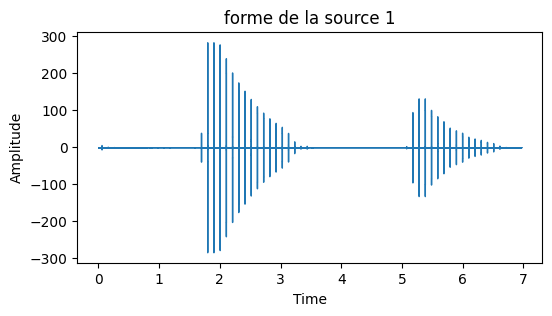

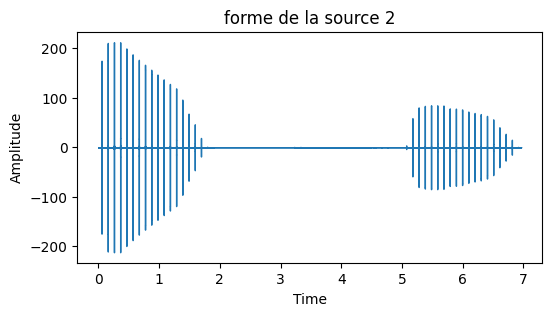

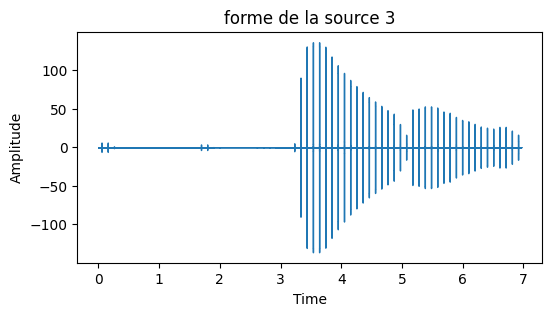

In [ ]:
# On retrouve la forme d'one en tracant les sources 

for i in range(0,S):
    plt.figure(figsize=(6,3))
    plt.title('forme de la source ' + str(i+1))
    signal = librosa.istft(filtered_source[i], hop_length=512)
    librosa.display.waveshow(signal, sr=sr)

    plt.xlabel('Time')
    plt.ylabel('Amplitude')

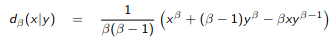
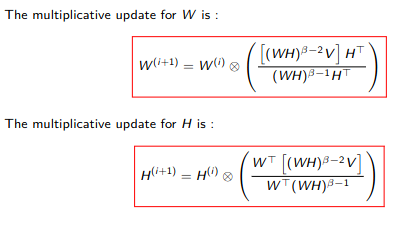

### 7) Réaliser les étapes précédentes en faisant varier β=2, β=1, β=0. Comparez et discutez

In [ ]:

# cette fois ci, on rajoute le parametre beta dans la mise a jour de H et W
def NMF_V2(V, S, beta, threshold ): 

    print("================ Beta = ", beta, "================")
    cout = []
    beta_divergence = 1
    
    K, N = np.shape(V)
    
    W = np.abs(np.random.randn(K, S))
    H = np.abs(np.random.randn(S, N))

    
    max = 0
    while beta_divergence >= threshold and max < 400:
        
         
        
        H = H*np.dot(W.transpose(), (V * np.dot(W, H)**(beta-2) )) / np.dot(W.transpose(), (np.dot(W,H))**(beta-1))
        W = W* np.dot((V * np.dot(W, H)**(beta-2)), H.transpose()) / np.dot((np.dot(W,H))**(beta-1), H.transpose())

        beta_divergence =  (1/2)*np.linalg.norm(V-np.dot(W,H))**2
        cout.append( beta_divergence )

        

        #on en plot 4 en tout, donc tous les 100/4 = 25
        if max ==0 or max == 5 or max==10 or max==20 or max == 50:
            plt.figure(figsize=(3,3))
    
            V_plot = plt.axes([0.35, 0.1, 1, 0.6])
            H_plot = plt.axes([0.35, 0.75, 1, 0.15])
            W_plot = plt.axes([0.1, 0.1, 0.2, 0.6])

            librosa.display.specshow(W,sr=sr, hop_length=512, ax=W_plot)
            librosa.display.specshow(H, sr=sr, hop_length=512, ax=H_plot)
            librosa.display.specshow(librosa.amplitude_to_db(W@H, ref=np.max),y_axis = 'hz', sr=sr, hop_length=512,x_axis ='time', ax=V_plot)
            V_plot.set_title('V')
            H_plot.set_title('H')
            W_plot.set_title('W')

            #axes
            V_plot.set_xlabel('Temps')
            V_plot.set_ylabel('Fréquence')
            H_plot.set_xlabel('Temps')
            H_plot.set_ylabel('Fréquence')
            W_plot.set_xlabel('Temps')
            W_plot.set_ylabel('Fréquence')
            

            plt.show()
        max += 1

        
    return W,H, cout 

# $\beta$ = 1

================ Beta =  1 ================


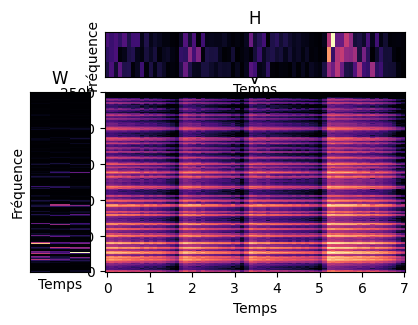

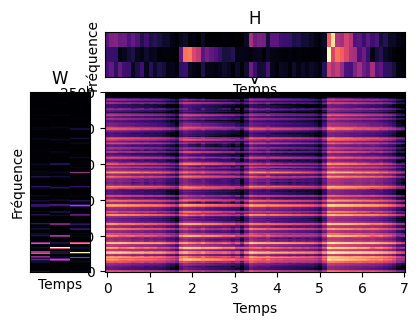

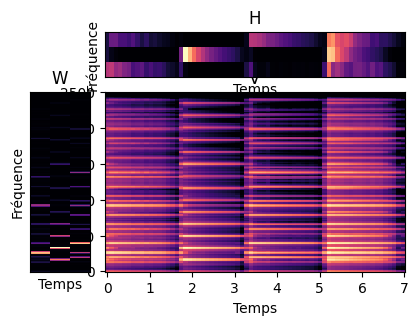

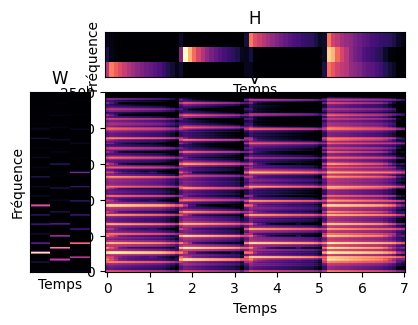

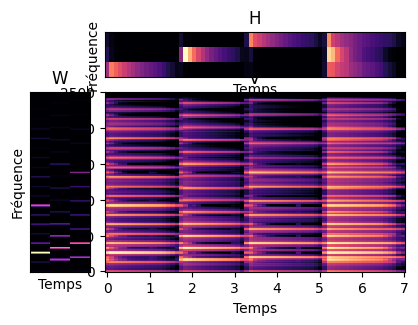

Text(0.5, 1.0, 'Fonction de cout pour beta = 1')

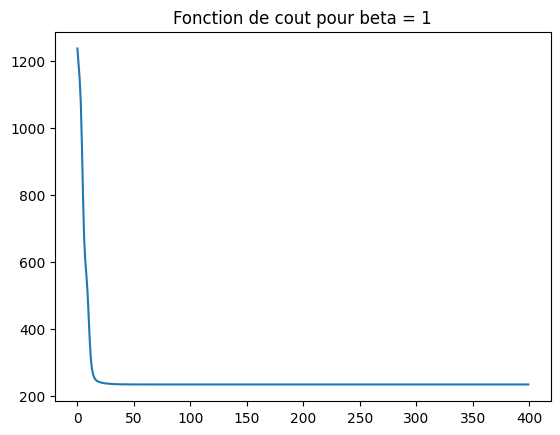

In [ ]:
W, H, cost_function = NMF_V2(V,3,1,0.05) 
plt.plot(cost_function)
plt.title('Fonction de cout pour beta = 1')

# $\beta$ = 0

================ Beta =  0 ================


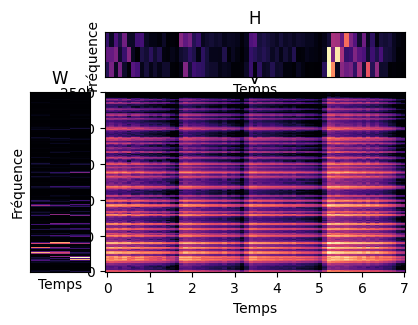

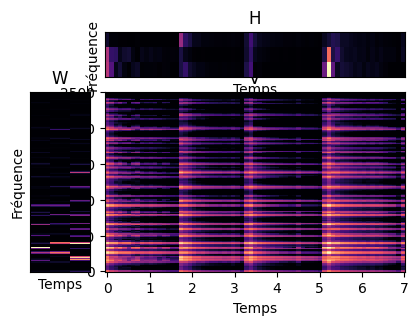

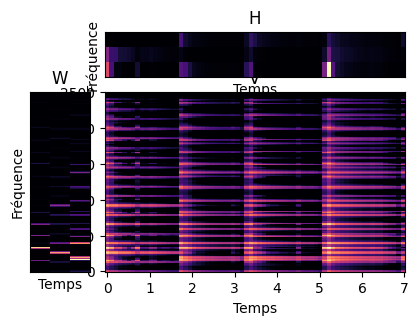

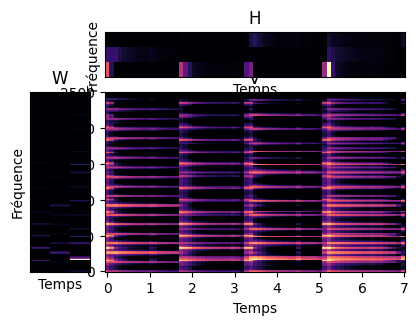

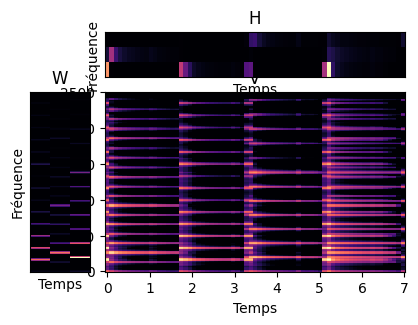

Text(0.5, 1.0, 'Fonction de cout pour beta = 0')

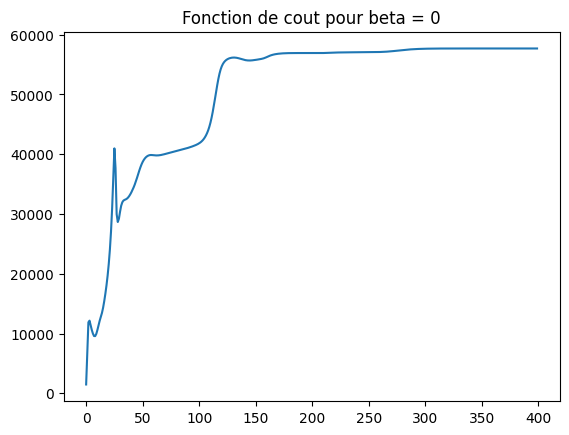

In [ ]:
W, H, cost_function = NMF_V2(V,3,0,0.05) 
plt.plot(cost_function)
plt.title('Fonction de cout pour beta = 0')


en comparant les résultats avec $\beta$ = 0,1,2 on constate que :

- pour $\beta$=1,2 on atteint un meme plateau de convergence. La fonction de cout décroit rapidement au bout d'une vingtaine d'itérations.
- pour $\beta$=0, cela ne fonctionne pas, la fonction de cout ne décroit pas.


Plus $\beta$ est grand, plus les contraintes sont fortes, meilleur est le résultat. 

### 8 )Réalisez les étapes précédentes en choisissant S = 4. Comparer avec les résultats obtenus pour S = 3. Interprétez

Pour S = 4, l'algorithme tent de séparer les 4 sources. On retrouve les 3 memes sources que précedemment. Cependant, une 4e ligne s'ajoute et qui s'active en même que une des 3 sources, avec une intensité plus faible. 


1) Soit cette source est autre source cachée et jouée en même temps que la source i. Dans ce cas, on peut essayer de séparer cette source de la source 1 en augmentant le nombre d'itérations.

2) Il se peut que cela aussi soit du au bruit ambiant que la nMF arrive a detecter : par exemple, les cordes du piano qui vibrent les notes annexes, le contact entre le doit et la touche du piano, etc. 


================ Beta =  2 ================


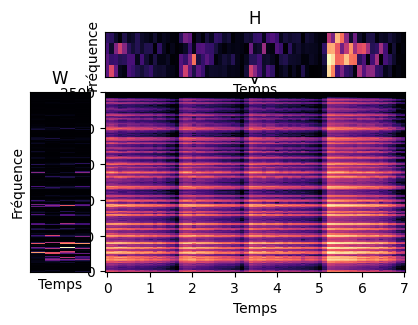

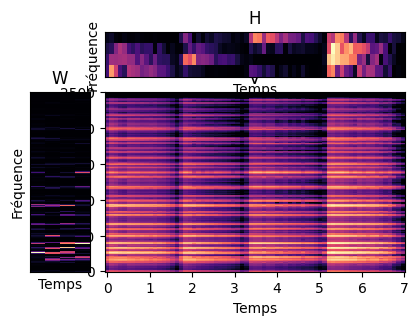

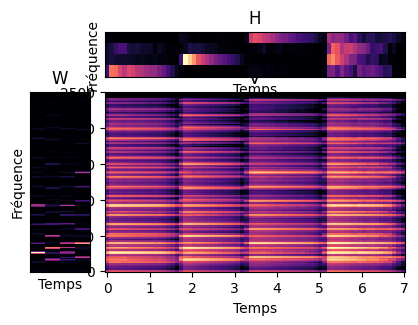

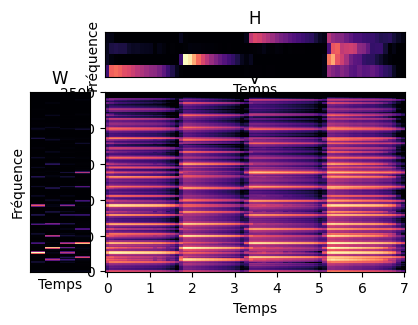

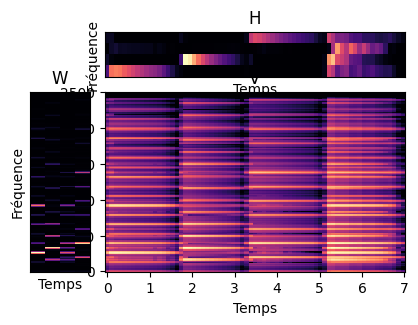

Text(0.5, 1.0, 'Fonction de cout pour beta = 2 et S = 4')

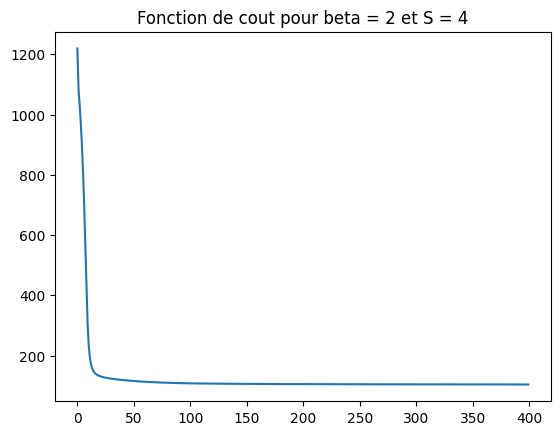

In [ ]:
W, H, cost_function = NMF_V2(V,4,2,0.05)
plt.plot(cost_function)
plt.title('Fonction de cout pour beta = 2 et S = 4')

essayons de separer les 4 sources via la fonction inverse de Fourier.

filtered source (4, 257, 69)


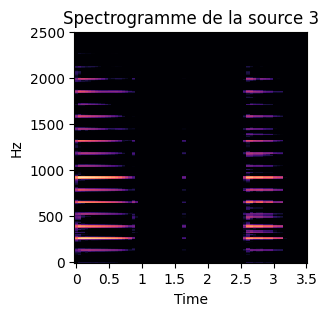

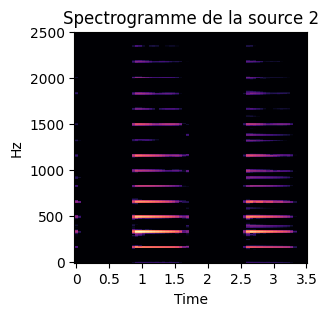

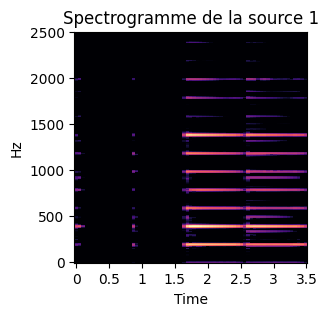

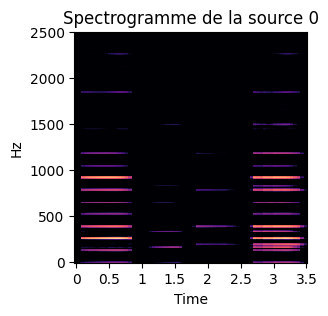

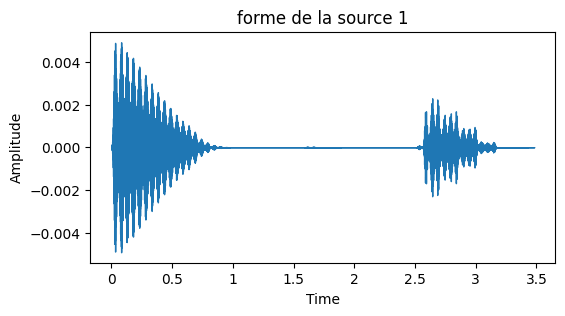

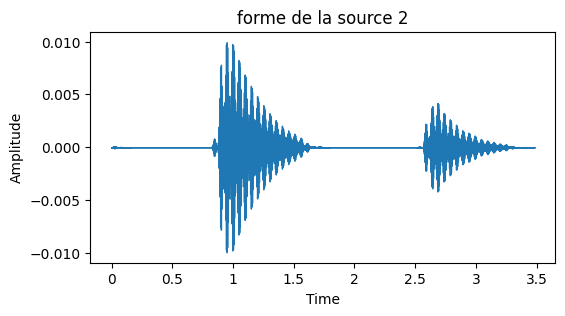

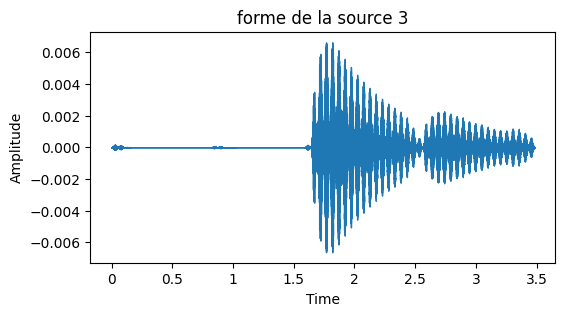

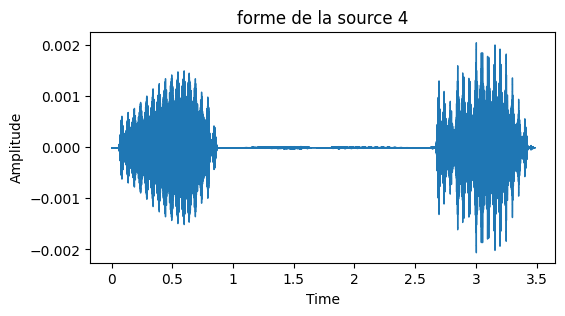

In [ ]:
filtered_source = []

for i in range(0,4):
    
    #source i
    wi_Hi =  np.dot(W[:,i].reshape(K,1), H[i,:].reshape(1,N))
    source = wi_Hi / np.sum(W@H, axis=0)*V
    filtered_source.append(source)

filtered_source = np.array(filtered_source)
print("filtered source", filtered_source.shape)

print_source(4, filtered_source)
# On retrouve la forme d'one en tracant les sources 

for i in range(0,4):
    plt.figure(figsize=(6,3))
    plt.title('forme de la source ' + str(i+1))
    signal = librosa.istft(filtered_source[i], hop_length=HOP)
    librosa.display.waveshow(signal, sr=sr)

    plt.xlabel('Time')
    plt.ylabel('Amplitude')

On arrive a séparer les 4 sources.